# CNN :  Google Bert Augmented Resturant data

In [1]:
# COLAB
from google.colab import files
from google.colab import drive
# SYS
import sys
# IPYNB
!pip install import-ipynb
import import_ipynb
# UTIL
import importlib.util

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.4 MB/s eta 0:00:00


In [2]:
!pip install import-ipynb

In [3]:
import pandas as pd
import re
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation , Flatten
from sklearn.preprocessing import LabelEncoder
from keras import utils as np_utils
from tensorflow.keras.layers import Dropout,Embedding , BatchNormalization
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
import xgboost as xgb
import sklearn.metrics as metrics

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Loading preprocessing class

In [5]:
#https://stackoverflow.com/questions/62117483/import-module-in-google-colab-from-google-drive-python
sys.path.append('/content/gdrive/MyDrive/CS--2/')
#import module_1_xml_to_df
#from module_1_xml_to_df import convert_xml_to_DataFrame
from module_2_preprocessing import Data_Preprocessing

## 1. Loading the data

In [6]:
!ls -l /content/gdrive/MyDrive/CS--2/

total 2364
-rw------- 1 root root 939797 Mar  3 06:39 'Copy of mod_4_CNN_google_bert_augmented.ipynb'
-rw------- 1 root root 378755 Jan 24 06:18  eda.ipynb
-rw------- 1 root root  62343 Mar 24 05:10  GANaugmentation.ipynb
-rw------- 1 root root  21072 Feb 28 18:52  mod_3_CNN_baseline_model.ipynb
-rw------- 1 root root 249234 Mar 28 05:14  mod_4_CNN_google_bert_augmented.ipynb
-rw------- 1 root root   9040 Mar 28 06:11  module_2_preprocessing.ipynb
-rw------- 1 root root   4438 Feb 28 19:07  module_2_preprocessing.py
drwx------ 2 root root   4096 Feb 28 19:10  __pycache__
drwx------ 2 root root   4096 Feb 28 18:35  Restaurent_data
-rw------- 1 root root 745776 Mar  3 10:42  trail.ipynb


In [9]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [12]:
restaurant_data = pd.read_csv("/content/gdrive/MyDrive/Code/Restaurent_data/augmented_data_restaurant_bert.csv")

In [13]:
restaurant_data.shape

(6088, 5)

In [14]:
restaurant_data.head()

,id,text,aspect_term,aspect_category,polarity
0,141.0,this dish is my favorite and i always get it w...,dish,food,positive
1,NaN,i think that it actually is absolutely brillia...,NaN,anecdotes/miscellaneous,positive
2,91.0,i will be going back and heartily recommend it!,NaN,anecdotes/miscellaneous,positive
3,1094.0,the food is amazing!!!!,food,food,positive
4,946.0,"we only ordered desserts and drinks, but no re...",drinks,service,negative


In [15]:
restaurant_data.groupby('aspect_category').size().sort_values(ascending=False)

,0
aspect_category,
anecdotes/miscellaneous,2091
food,1692
service,952
ambience,784
price,569


In [16]:
catagories = restaurant_data['aspect_category'].unique()
catagories , len(catagories)

(array(['food', 'anecdotes/miscellaneous', 'service', 'ambience', 'price'],
       dtype=object),
 5)

## 2. Aspect Based Sentiment Analysis

In [17]:
X = restaurant_data['text']
Y = restaurant_data['aspect_category']

### 2.1. Splitting the data

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [19]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4870,) (4870,)
(1218,) (1218,)


In [20]:
dp = Data_Preprocessing()

In [23]:
!pip install nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [24]:
X_train_review = dp.preprocess_text(X_train)

100%|██████████| 4870/4870 [00:14<00:00, 342.43it/s]


In [25]:
X_test_review = dp.preprocess_text(X_test)

100%|██████████| 1218/1218 [00:02<00:00, 453.06it/s]


In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 6000 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)
X_train_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(X_train_review))
X_test_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(X_test_review))

In [28]:
label_encoder = LabelEncoder()
integer_category = label_encoder.fit_transform(y_train)
encoded_y_train = np_utils.to_categorical(integer_category)

integer_category = label_encoder.fit_transform(y_test)
encoded_y_test = np_utils.to_categorical(integer_category)

### 2.2 CNN Aspect Based model

In [29]:
acbsa_model = Sequential()
acbsa_model.add(Dense(512, input_shape=(6000,), activation='relu'))
#acbsa_model.add((BatchNormalization()))
acbsa_model.add((Dense(256, activation='relu')))
acbsa_model.add((Dropout(0.3)))
acbsa_model.add((Dense(128, activation='relu')))
#acbsa_model.add((Dropout(0.1)))
#acbsa_model.add((Dense(64, activation='relu')))
acbsa_model.add(Dense(5, activation='softmax'))
#compile model
acbsa_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
acbsa_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     3,072,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,237,381 (12.35 MB)

 Trainable params: 3,237,381 (12.35 MB)

 Non-trainable params: 0 (0.00 B)

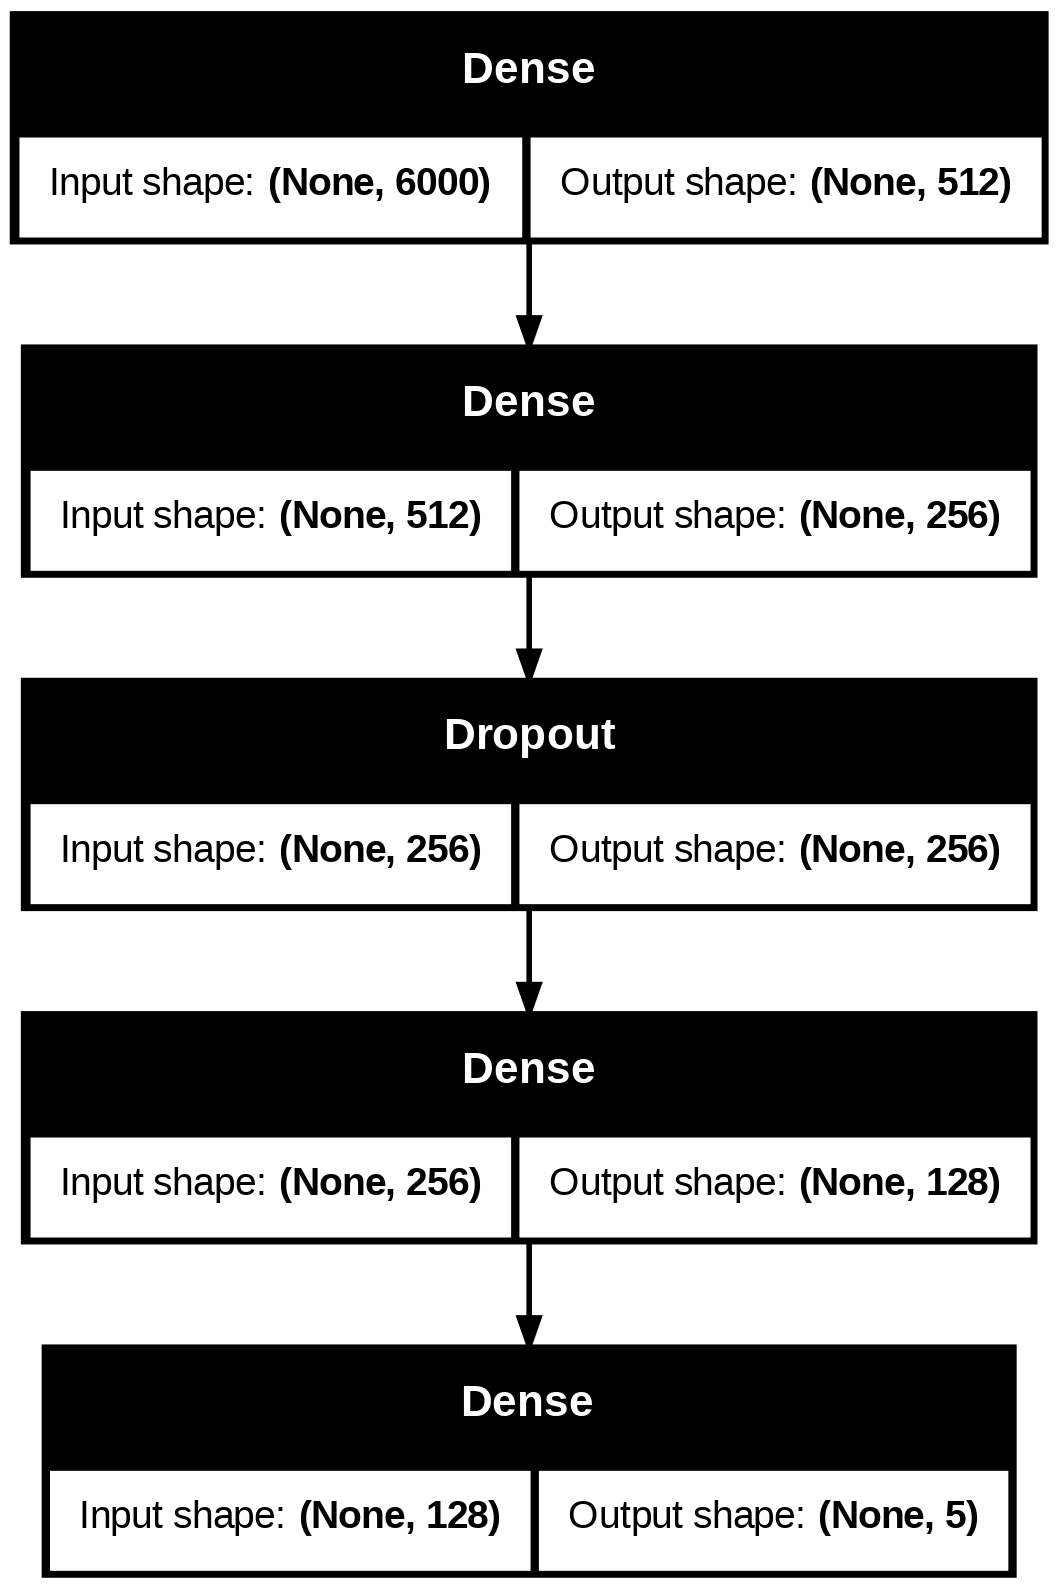

In [31]:
plot_model(acbsa_model, 'model_1.png',show_shapes=True)

In [32]:
#fit aspect classifier
history = acbsa_model.fit(X_train_tokenized , encoded_y_train , validation_data=(X_test_tokenized ,encoded_y_test) , epochs= 5, verbose=1)

Epoch 1/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.5104 - loss: 1.2286 - val_accuracy: 0.8645 - val_loss: 0.4119
Epoch 2/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9510 - loss: 0.1857 - val_accuracy: 0.9039 - val_loss: 0.3588
Epoch 3/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9933 - loss: 0.0318 - val_accuracy: 0.8998 - val_loss: 0.4305
Epoch 4/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9984 - loss: 0.0058 - val_accuracy: 0.9146 - val_loss: 0.4385
Epoch 5/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9146 - val_loss: 0.4678


In [34]:
predicted_cat = label_encoder.inverse_transform(np.argmax(acbsa_model.predict(X_test_tokenized), axis=-1)) # Use predict and argmax
#print(new_polarity)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [35]:
predicted_cat[0:10]

array(['anecdotes/miscellaneous', 'anecdotes/miscellaneous',
       'anecdotes/miscellaneous', 'anecdotes/miscellaneous', 'food',
       'food', 'price', 'food', 'anecdotes/miscellaneous', 'food'],
      dtype=object)

### 2.3 Classification report

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_cat ,target_names=catagories))

                         precision    recall  f1-score   support

                   food       0.95      0.85      0.90       164
anecdotes/miscellaneous       0.90      0.97      0.93       400
                service       0.93      0.91      0.92       355
               ambience       0.95      0.88      0.91       113
                  price       0.88      0.88      0.88       186

               accuracy                           0.91      1218
              macro avg       0.92      0.90      0.91      1218
           weighted avg       0.92      0.91      0.91      1218



### Observation :
This is the classification report of aspect category based sentiment model showing the precision, recall, f1_score and support values for all 5 unique catagories with accuracy 91 percent

In [37]:
import matplotlib.pyplot as plt
def plot_accuracy(history, miny=None):
  acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  if miny:
    plt.ylim(miny, 1.0)
  plt.title('accuracy')
  plt.xlabel('epoch')
  plt.figure()

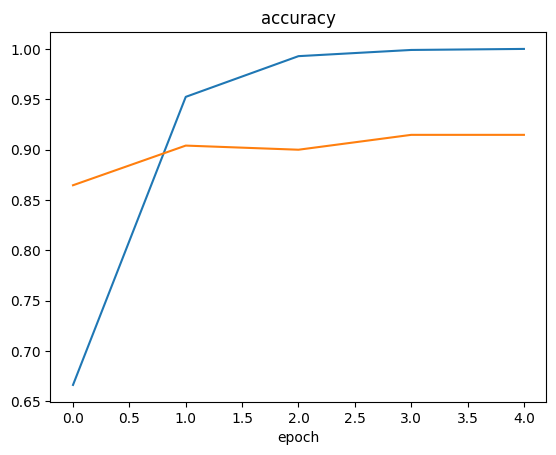

<Figure size 640x480 with 0 Axes>

In [38]:
plot_accuracy(history)

### 2.4.  Confusion matrix Representation

In [39]:
# code borrowed from Microsoft Malware Detection Assignment
def plot_confusion_matrix(test_y, predict_y ,labels):
    C = confusion_matrix(test_y, predict_y)      # calculation of confusion matrix
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y))    # number of misclassified points while predicting y

    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))

    labels = labels
    cmap=sns.light_palette("purple")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))

    # representing B in heatmap format
    print("-"*50, "Recall matrix" , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

Number of misclassified points  0.08538587848932677
-------------------------------------------------- Confusion matrix --------------------------------------------------


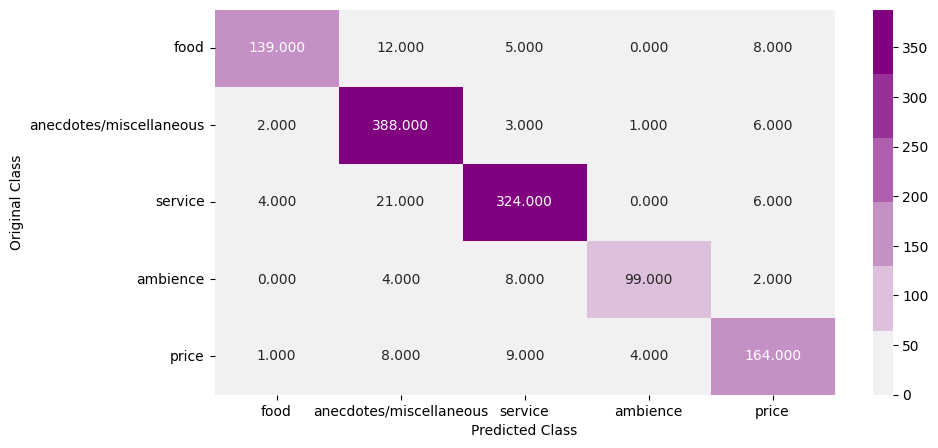

-------------------------------------------------- Precision matrix --------------------------------------------------


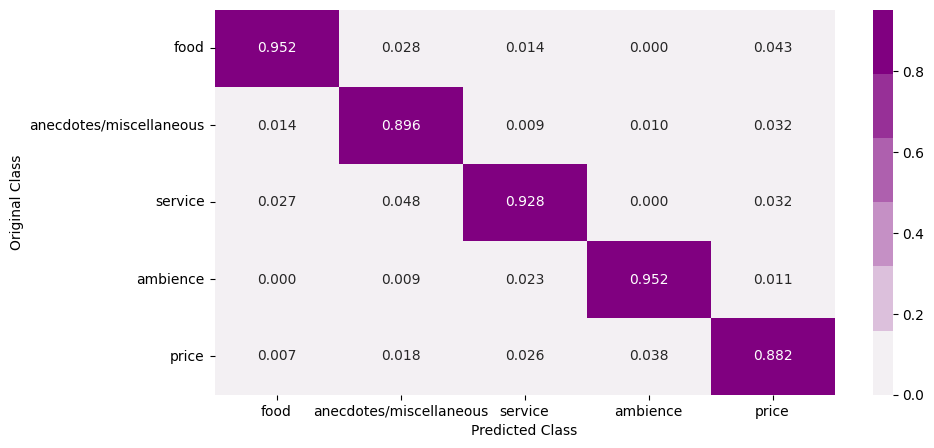

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


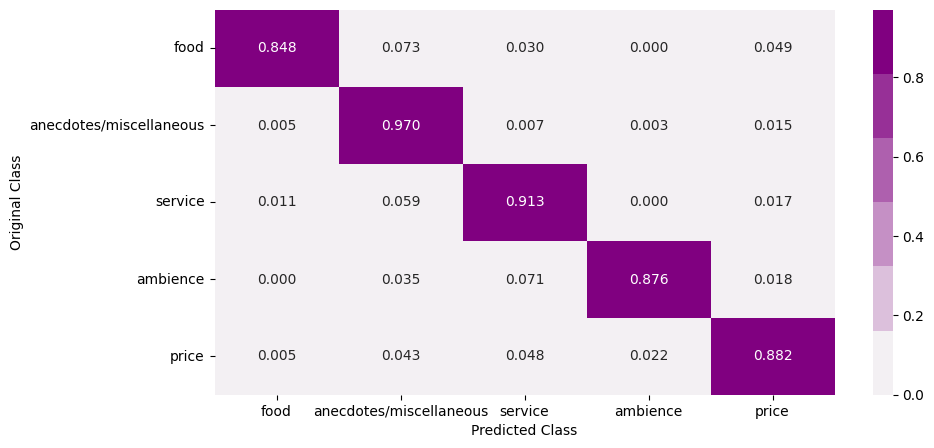

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [40]:
plot_confusion_matrix(y_test,  predicted_cat, catagories)

## 3. Polarity Based sentiment model

In [41]:
X = restaurant_data['text']
Y = restaurant_data['polarity']

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [43]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4870,) (4870,)
(1218,) (1218,)


In [44]:
label_encoder = LabelEncoder()
integer_category = label_encoder.fit_transform(y_train)
encoded_y_train = np_utils.to_categorical(integer_category)

integer_category = label_encoder.fit_transform(y_test)
encoded_y_test = np_utils.to_categorical(integer_category)

### 3.1 CNN sentiment model

In [45]:
sentiment_model = Sequential()
sentiment_model.add(Dense(512, input_shape=(6000,), activation='relu'))
sentiment_model.add((Dense(256, activation='relu')))
sentiment_model.add((Dropout(0.3)))
sentiment_model.add((Dense(128, activation='relu')))
sentiment_model.add(Dense(4, activation='softmax'))
sentiment_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
sentiment_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │     3,072,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,237,252 (12.35 MB)

 Trainable params: 3,237,252 (12.35 MB)

 Non-trainable params: 0 (0.00 B)

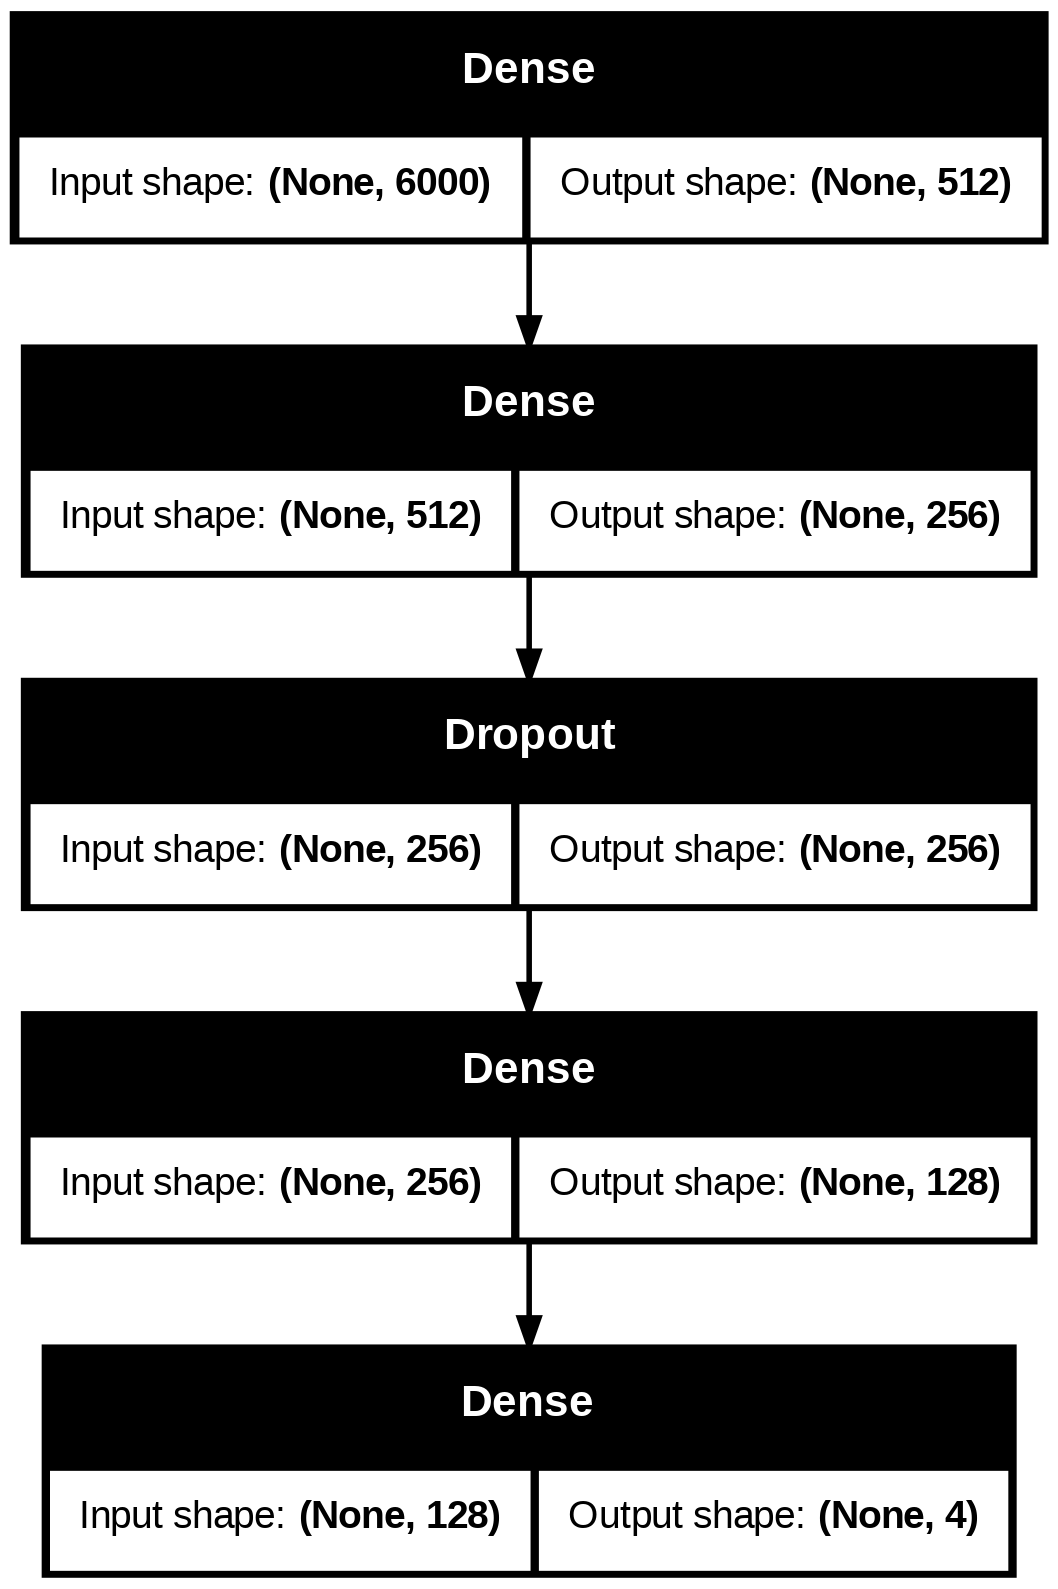

In [47]:
plot_model(sentiment_model, 'model_2.png',show_shapes=True)

In [48]:
#fit aspect classifier
history = sentiment_model.fit(X_train_tokenized , encoded_y_train , validation_data=(X_test_tokenized ,encoded_y_test) , epochs=6, verbose=1)

Epoch 1/6
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.6025 - loss: 1.0154 - val_accuracy: 0.8358 - val_loss: 0.4717
Epoch 2/6
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9254 - loss: 0.2195 - val_accuracy: 0.8916 - val_loss: 0.3243
Epoch 3/6
153/153 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.9917 - loss: 0.0383 - val_accuracy: 0.9064 - val_loss: 0.3991
Epoch 4/6
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9984 - loss: 0.0084 - val_accuracy: 0.9048 - val_loss: 0.4309
Epoch 5/6
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9994 - loss: 0.0057 - val_accuracy: 0.9056 - val_loss: 0.4406
Epoch 6/6
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.8998 - val_loss: 0.4628


In [51]:
predicted_polarity = label_encoder.inverse_transform(np.argmax(sentiment_model.predict(X_test_tokenized), axis=-1)) # Use predict and argmax to get predicted classes

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


In [52]:
predicted_polarity[0:10]

array(['positive', 'positive', 'negative', 'neutral', 'positive',
       'positive', 'negative', 'positive', 'positive', 'conflict'],
      dtype=object)

In [53]:
polarity = restaurant_data["polarity"].unique()
polarity

array(['positive', 'negative', 'conflict', 'neutral'], dtype=object)

### 3.2 Classification repoort

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_polarity ,target_names= polarity))

              precision    recall  f1-score   support

    positive       0.82      0.73      0.77        55
    negative       0.87      0.87      0.87       273
    conflict       0.79      0.89      0.84       177
     neutral       0.95      0.93      0.94       713

    accuracy                           0.90      1218
   macro avg       0.86      0.85      0.85      1218
weighted avg       0.90      0.90      0.90      1218



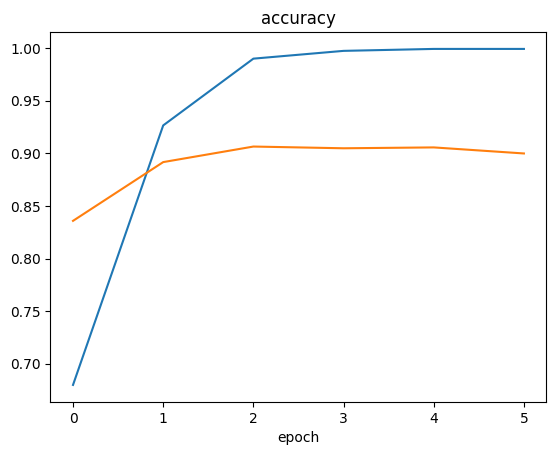

<Figure size 640x480 with 0 Axes>

In [55]:
plot_accuracy(history)

### 3.3 Confusion matrix representation

Number of misclassified points  0.10016420361247948
-------------------------------------------------- Confusion matrix --------------------------------------------------


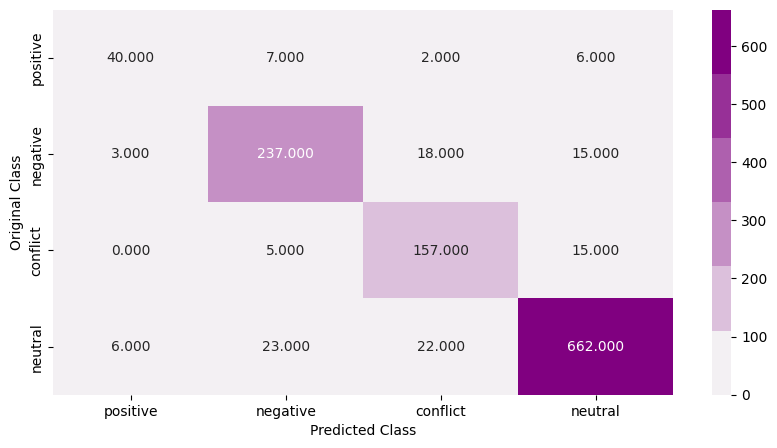

-------------------------------------------------- Precision matrix --------------------------------------------------


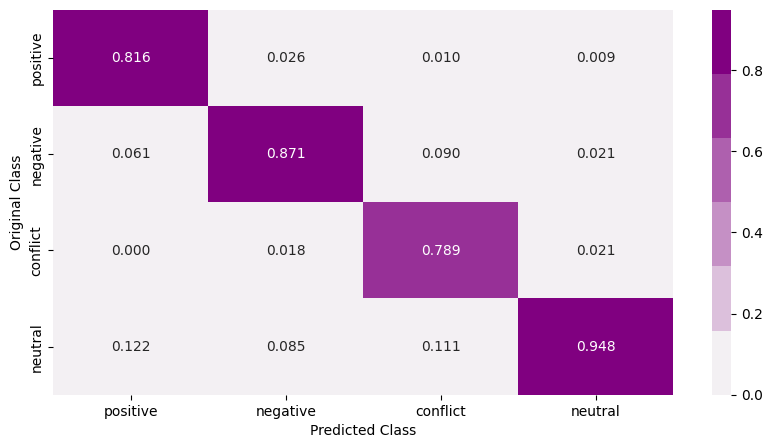

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


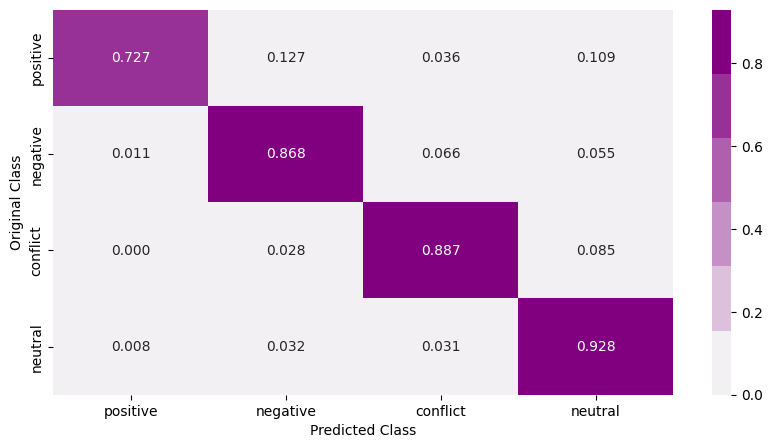

Sum of rows in precision matrix [1. 1. 1. 1.]


In [56]:
plot_confusion_matrix(y_test,  predicted_polarity, polarity)

## 4. creating a resultant dataframe

In [57]:
def create_result_dataframe(pred_1,pred_2):
  # Calling DataFrame constructor on predicted outputs
  resultant_df = pd.DataFrame(list(zip(pred_1,pred_2)), columns = ["predicted_catagories" , "predicted_polarity"])
  result  = pd.crosstab(resultant_df.predicted_catagories,resultant_df.predicted_polarity ,margins = True , margins_name = "Total")
  result["Ranking"] = ( result.Total/resultant_df.shape[0]) * 5.0
  result["Negative in %"] = (result.negative/result.Total) * 100
  result["Neutral in %"] = (result.neutral/result.Total) * 100
  result["Positive in %"] = (result.positive/result.Total) * 100
  result["conflict in %"] = (result.conflict/result.Total) * 100
  del result["negative"]
  del result["neutral"]
  del result["positive"]
  del result["Total"]
  del result["conflict"]

  return result


In [58]:
result = create_result_dataframe(predicted_cat,predicted_polarity)

In [59]:
result

predicted_polarity,Ranking,Negative in %,Neutral in %,Positive in %,conflict in %
predicted_catagories,,,,,
ambience,0.599343,26.712329,6.164384,60.958904,6.164384
anecdotes/miscellaneous,1.777504,16.628176,32.563510,48.267898,2.540416
food,1.432677,14.899713,9.742120,71.346705,4.011461
price,0.426929,36.538462,3.846154,52.884615,6.730769
service,0.763547,38.172043,5.913978,51.612903,4.301075
Total,5.000000,22.331691,16.338259,57.307061,4.022989


### Observation :
   Above result shows that the Ranking and all Polarities in percentages for all aspect catagories from which we can see that anecdotes/miscellaneous have the highest ranking of 1.79 . and food catagory have highest positive polarity